In [2]:
!pip install pandas
!pip install scikit-learn
!pip install torch
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 3.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 4.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 44.7 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 76.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.6/766.6 MB 71.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 65.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 69.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 77.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch

from torch.utils.data import DataLoader, TensorDataset


# 1. Load the dataset
data = pd.read_csv('league_of_legends_data_large.csv')

# 2. Split data into features and target
X = data.drop('win', axis=1)
y = data['win']

# 3. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 5. Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Print tensor shapes
print(f'X_train_tensor shape: {X_train_tensor.shape}')
print(f'X_test_tensor shape: {X_test_tensor.shape}')
print(f'y_train_tensor shape: {y_train_tensor.shape}')
print(f'y_test_tensor shape: {y_test_tensor.shape}')

# Create DataLoader for training and test sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

X_train_tensor shape: torch.Size([800, 8])
X_test_tensor shape: torch.Size([200, 8])
y_train_tensor shape: torch.Size([800])
y_test_tensor shape: torch.Size([200])


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

# 1. Define the Logistic Regression Model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

# Set input_dim: Use X_train.shape[1] to get the number of features from the training data (X_train)
input_dim = X_train.shape[1]

# Initialize the model: Create an instance of the LogisticRegressionModel class
model = LogisticRegressionModel(input_dim)

# Loss Function: Use BCELoss() from torch.nn (Binary Cross-Entropy Loss)
criterion = nn.BCELoss()

# Optimizer: Initialize the optimizer using optim.SGD() with a learning rate of 0.01
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Print model, criterion, and optimizer to verify
print(model)
print(criterion)
print(optimizer)

LogisticRegressionModel(
  (linear): Linear(in_features=8, out_features=1, bias=True)
)
BCELoss()
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [5]:
epochs = 1000
train_losses = []
test_losses = []

for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Evaluation phase on test set
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            test_outputs = model(X_batch)
            loss = criterion(test_outputs, y_batch.unsqueeze(1).float())
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    
    if epoch%100 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch [1/1000], Train Loss: 0.7110, Test Loss: 0.7087
Epoch [101/1000], Train Loss: 0.6898, Test Loss: 0.7007
Epoch [201/1000], Train Loss: 0.6897, Test Loss: 0.6988
Epoch [301/1000], Train Loss: 0.6896, Test Loss: 0.6997
Epoch [401/1000], Train Loss: 0.6905, Test Loss: 0.7003
Epoch [501/1000], Train Loss: 0.6901, Test Loss: 0.7009
Epoch [601/1000], Train Loss: 0.6901, Test Loss: 0.6987
Epoch [701/1000], Train Loss: 0.6903, Test Loss: 0.6993
Epoch [801/1000], Train Loss: 0.6901, Test Loss: 0.6999
Epoch [901/1000], Train Loss: 0.6901, Test Loss: 0.6988


In [6]:
from sklearn.metrics import accuracy_score

train_outputs = model(X_train_tensor)
train_predicted = (train_outputs >= 0.5).float()

test_outputs = model(X_test_tensor)
test_predicted = (test_outputs >= 0.5).float()

train_accuracy = accuracy_score(y_train_tensor, train_predicted)
test_accuracy = accuracy_score(y_test_tensor, test_predicted)

# Print training and test accuracies
print(f'Train Accuracy: {train_accuracy * 100:.2f}%')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Train Accuracy: 54.00%
Test Accuracy: 51.00%


In [7]:

# Optimizer: Initialize the optimizer using optim.SGD() with a learning rate of 0.01
optimizer_wd = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)
print(optimizer)


SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [8]:
epochs = 1000
train_losses = []
test_losses = []

for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer_wd.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Evaluation phase on test set
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            test_outputs = model(X_batch)
            loss = criterion(test_outputs, y_batch.unsqueeze(1).float())
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    
    if epoch%100 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch [1/1000], Train Loss: 0.6899, Test Loss: 0.7007
Epoch [101/1000], Train Loss: 0.6898, Test Loss: 0.7011
Epoch [201/1000], Train Loss: 0.6903, Test Loss: 0.6999
Epoch [301/1000], Train Loss: 0.6904, Test Loss: 0.7006
Epoch [401/1000], Train Loss: 0.6893, Test Loss: 0.7010
Epoch [501/1000], Train Loss: 0.6902, Test Loss: 0.7006
Epoch [601/1000], Train Loss: 0.6906, Test Loss: 0.7011
Epoch [701/1000], Train Loss: 0.6900, Test Loss: 0.6997
Epoch [801/1000], Train Loss: 0.6899, Test Loss: 0.6993
Epoch [901/1000], Train Loss: 0.6899, Test Loss: 0.7014


In [9]:
train_outputs = model(X_train_tensor)
train_predicted = (train_outputs >= 0.5).float()

test_outputs = model(X_test_tensor)
test_predicted = (test_outputs >= 0.5).float()

train_accuracy = accuracy_score(y_train_tensor, train_predicted)
test_accuracy = accuracy_score(y_test_tensor, test_predicted)

# Print training and test accuracies
print(f'Train Accuracy: {train_accuracy * 100:.2f}%')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Train Accuracy: 54.25%
Test Accuracy: 51.00%


Confusion Matrix:
[[40 55]
 [43 62]]


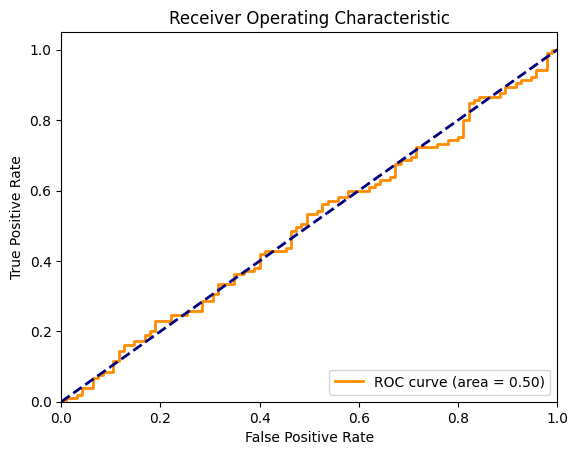

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.48      0.42      0.45        95
     Class 1       0.53      0.59      0.56       105

    accuracy                           0.51       200
   macro avg       0.51      0.51      0.50       200
weighted avg       0.51      0.51      0.51       200



In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report


cm = confusion_matrix(y_test_tensor, test_predicted)
print("Confusion Matrix:")
print(cm)

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_tensor.detach().numpy(), test_outputs.detach().numpy())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Classification Report
report = classification_report(y_test_tensor, test_predicted, target_names=['Class 0', 'Class 1'])
print("Classification Report:")
print(report)

In [12]:

from torcheval.metrics import BinaryAccuracy

# Save the model's state dictionary
torch.save(model.state_dict(), 'logistic_regression_model.pth')

# Create a new instance of the model
loaded_model = LogisticRegressionModel(input_dim)

# Load the saved state dictionary into the new model instance
loaded_model.load_state_dict(torch.load('logistic_regression_model.pth'))

# Set the model to evaluation mode
loaded_model.eval()

# Evaluate the loaded model on the test dataset\

test_outputs_loaded = loaded_model(X_test_tensor)
test_predicted_loaded = (test_outputs_loaded >= 0.5).float()

with torch.no_grad():
    metric = BinaryAccuracy()
    metric.update(test_predicted_loaded.squeeze(), y_test_tensor)
    test_accuracy_loaded = metric.compute()

# Print test accuracy of the loaded model
print(f'Test Accuracy of Loaded Model: {test_accuracy_loaded * 100:.2f}%')

Test Accuracy of Loaded Model: 51.00%


In [15]:
# Define the Logistic Regression Model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

# Define learning rates to test
learning_rates = [0.01, 0.05, 0.1]
num_epochs = 100
best_accuracy = 0
best_lr = None

# Loop over each learning rate
for lr in learning_rates:
    # Reinitialize the model and optimizer for each learning rate
    model = LogisticRegressionModel(input_dim)
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=0.01)
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    
    # Evaluate the model on the test set
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_predicted = (test_outputs >= 0.5).float()
        test_accuracy = accuracy_score(y_test_tensor, test_predicted)
    
    # Track the best learning rate
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_lr = lr
    
    print(f'Learning Rate: {lr}, Test Accuracy: {test_accuracy * 100:.2f}%')

# Print the best learning rate and its corresponding accuracy
print(f'Best Learning Rate: {best_lr}, Best Test Accuracy: {best_accuracy * 100:.2f}%')

ValueError: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])) is deprecated. Please ensure they have the same size.

In [ ]:
weights = model.linear.weight.detach().numpy().flatten()
feature_names = ['win', 'kills', 'deaths', 'assists', 'gold_earned', 'cs', 'wards_placed', 'wards_killed', 'damage_dealt']

# Create a DataFrame with feature names and their corresponding importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': weights
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance using a bar plot
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()